# Computing perspective fields based on pin-hole camera parameters
## Read an equirectangular image (in this example reading an exr file)

In [1]:
import numpy as np
import ezexr # read exr file


img_format='RGB'
input_pano = "../assets/imgs/quattro_canti_2k.exr"
data = ezexr.imread(input_pano, rgb=False)
equi_img = np.stack([data['R'], data['G'], data['B']], axis=-1)
equi_img = np.clip(np.power(equi_img, 0.45), 0, 1)
equi_img = np.uint8(equi_img*255)

3


## Crop the panorama

In [2]:
from perspective2d.utils.panocam import PanoCam
roll = 0
yaw = 180
pitch = 20
vfov = 70
width = 640
height = 480
rgb = PanoCam.crop_equi(
    equi_img=equi_img, 
    vfov=vfov, 
    im_w=width, 
    im_h=height, 
    azimuth=yaw,
    elevation=pitch, 
    roll=roll, 
    ar=width/height, 
    mode='bilinear'
)

/home/jinlinyi/.pyenv/versions/anaconda3-2022.10spdrdf/envs/perspective/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jinlinyi/.pyenv/versions/anaconda3-2022.10spdrdf/envs/perspective/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Calculate perspective fields based on pin-hole camera parameters

In [3]:
up = PanoCam.get_up(np.radians(vfov), width, height, np.radians(pitch), np.radians(roll))
lati = PanoCam.get_lat(np.radians(vfov), width, height, np.radians(pitch), np.radians(roll))

## Visualize perspective fields

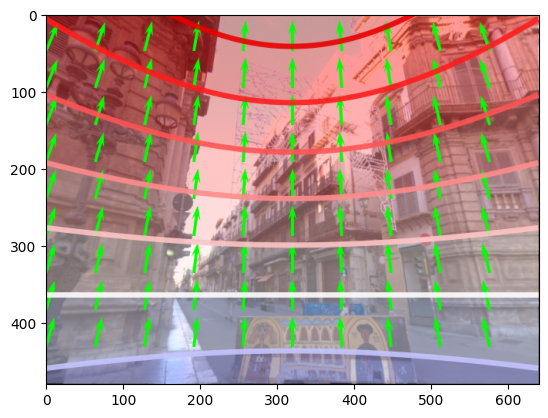

In [4]:
import matplotlib.pyplot as plt
from perspective2d.utils import draw_perspective_fields
blend = draw_perspective_fields(rgb, up, np.radians(lati))
plt.imshow(blend)
plt.show()